# Classificator with all data augmentation technqiues on positive events (including combinations)

In [1]:
from lib import Augmentation_methods
from lib import data_preparation

import matplotlib.pyplot as plt
from scipy.signal import stft
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from IPython.display import clear_output

2022-12-10 16:11:56.426730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
BASEDIR = Path("/store/projects/fallki/")
FAKEDIR = BASEDIR / "Fake-Events" / "2. Fake-Events Messung"

# BASEDIR = pathlib.Path('/store/projects/fallki/')
# FAKEDIR = pathlib.Path('Fake-Events/2. Fake-Events Messung/')
df_fake = pd.read_parquet(BASEDIR / FAKEDIR / 'gSensoren_FakeEvents.parquet')

### Positive evennts

In [3]:
F = data_preparation.fake_lab_data()
Positive_events = F[3]
Positive_labels = F[4]

/home/ing2146/Final/SNEHA/lib/data_preparation.py:202: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  All_Events_Data = np.array(All_Events_Data)[shuffler]
/home/ing2146/Final/SNEHA/lib/data_preparation.py:226: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df_fake_dummy_Data = np.array(df_fake_dummy_Data)


In [ ]:
Positive_events

In [ ]:
Positive_labels

### Augmented positive data preparation from different DA techniques

In [4]:
augmented_dummy = []
augmented_dummy_label = []

for i, event in enumerate(Positive_events): 
    
    #Jittering
    Noise_dummy = Augmentation_methods.add_white_noise(event, 0.15) 
    augmented_dummy.append(Noise_dummy)
    augmented_dummy_label.append(Positive_labels[i])
    
    #Magnitude Warping
    magnitude_warped_dummy =  Augmentation_methods.magnitudewarping(event,0.1, 20) 
    augmented_dummy.append(magnitude_warped_dummy[1])
    augmented_dummy_label.append(Positive_labels[i])
    
    #Time Warping
    Time_warped_dummy = Augmentation_methods.DA_TimeWarp(event, 0.3, 4) 
    augmented_dummy.append(Time_warped_dummy[2])
    augmented_dummy_label.append(Positive_labels[i])
    
    #Window Warping
    window_warped_dummy = Augmentation_methods.windowWarp(event, window_ratio=0.1, scales=[0.5, 2.]) 
    augmented_dummy.append(window_warped_dummy)
    augmented_dummy_label.append(Positive_labels[i])
    
    #Permutation
    permutated_dummy = Augmentation_methods.Permutation(event, nPerm=4, minSegLength=10) 
    augmented_dummy.append(permutated_dummy[1])
    augmented_dummy_label.append(Positive_labels[i])
    
    #Jittering + Magnitude warping
    curve_JMW, jittered_magnitude_warped_dummy  =  Augmentation_methods.magnitudewarping((Augmentation_methods.add_white_noise(event, 0.50)),0.1, 10)
    augmented_dummy.append(jittered_magnitude_warped_dummy)
    augmented_dummy_label.append(Positive_labels[i])
    
    #Jittering + Time warping
    jittered_time_curve,Jittered_Time_warped_dummy, Jittered_Time_warped_dummy_stft = Augmentation_methods.DA_TimeWarp((Augmentation_methods.add_white_noise(event, 0.50)), 0.3, 4)
    augmented_dummy.append(Jittered_Time_warped_dummy_stft)
    augmented_dummy_label.append(Positive_labels[i])
    
    #Jittering + window warping
    Jittered_window_warped_dummy = Augmentation_methods.windowWarp((Augmentation_methods.add_white_noise(event, 0.50)), window_ratio=0.1, scales=[0.5, 2.])
    augmented_dummy.append(Jittered_window_warped_dummy)
    augmented_dummy_label.append(Positive_labels[i])
    
    #magnitude warping + window warping
    mag_warped  =  Augmentation_methods.magnitudewarping(event,0.1, 10)
    mag_window_warped_dummy = Augmentation_methods.windowWarp(mag_warped[1] , window_ratio=0.1, scales=[0.5, 2.])
    augmented_dummy.append(mag_window_warped_dummy)
    augmented_dummy_label.append(Positive_labels[i])
    
    #Time warping + window warping
    t_warped = Augmentation_methods.DA_TimeWarp(event, 0.3, 4)
    time_window_warped_dummy = Augmentation_methods.windowWarp(t_warped[2] , window_ratio=0.1, scales=[0.5, 2.])
    augmented_dummy.append(time_window_warped_dummy)
    augmented_dummy_label.append(Positive_labels[i])
    
    
    
augmented_dummy_array = np.array(augmented_dummy)  
augmented_dummy_label = np.array(augmented_dummy_label)

/tmp/ipykernel_2397517/1342348093.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  augmented_dummy_array = np.array(augmented_dummy)


In [5]:
augmented_dummy_array_df =pd.DataFrame(augmented_dummy_array,columns=['z'])
augmented_dummy_array_df['event'] = augmented_dummy_label
#augmented_dummy_array_df

## Data Preparation  

In [6]:
def SignalToSpectrum(signal, samplerate=1600):
    SIGNAL_LENGTH = samplerate * 10
    F = stft(signal[:SIGNAL_LENGTH], 1600, nperseg=128)[2]
    F = F[2:,]
    return np.expand_dims(np.abs(F), axis=2) # Add extra dimension for TF Conv2D

### Augmented dummy data 

In [7]:
M = []
for i in range(len(augmented_dummy_array_df)):
    M.append({"event": augmented_dummy_array_df.event[i] ,
              "istSturz": int((augmented_dummy_array_df.event[i]) == "Dummy"),
              "signalLenght": len(augmented_dummy_array_df.z[i]),
              "spectrum": SignalToSpectrum(augmented_dummy_array_df.z[i])})
augmented_df = pd.DataFrame.from_dict(M)

In [ ]:
augmented_df

In [8]:
#shuffle the final dataframe
augmented_df = augmented_df.sample(frac=1).reset_index(drop=True)

In [ ]:
augmented_df.head(50)

In [9]:
# normalize the spectrum to facilitate training
augmented_df["normalizedSpectrum"] = augmented_df["spectrum"] / augmented_df["spectrum"].map(np.max).max()

In [ ]:
augmented_df

## Model

In [10]:
# initialize a sequential network model https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
mdl = Sequential()
# as a first layer add a convolutional layer https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
# the input shape is our image size 63x251 px the additional,1 is the channel feature we do not need and therefore leave at 1
# the Integer 8 here is the dimensionality of the output space (i.e. the number of output filters in the convolution).
# (63, 5) specifies the kernel size. the first dimension gives the entire length of the images rows, we chose this because we want 
# to have information about all the different frequencies at the same time, the 5 can be varied but specifies how long the time interval is
# which is brought into context with one another
mdl.add(Conv2D(8, (63, 5), activation="relu", input_shape=(63, 251, 1)))
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D The pooling layer just keeps the max value px in a (1, 4) window
mdl.add(MaxPooling2D((1, 4)))
# removes the 2 dimensionality of the data -> just a vector now https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten
mdl.add(Flatten())
# this is just your usual dense connected layer of a NN https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense, the 1 specifies the 
# number of output parameters we want, which is just 1
mdl.add(Dense(1))
# configures the model for training https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
mdl.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
# this just prints the model summery below
mdl.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 247, 8)         2528      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 61, 8)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 488)               0         
                                                                 
 dense (Dense)               (None, 1)                 489       
                                                                 
Total params: 3,017
Trainable params: 3,017
Non-trainable params: 0
_________________________________________________________________


2022-12-10 16:13:56.526755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
X = np.stack(augmented_df["normalizedSpectrum"].to_list())
y = augmented_df["istSturz"].to_numpy()

# split data in train and test set
train, test = train_test_split(range(len(y)), test_size=0.2,stratify= y)
# how many of the respective events are contained in the test set
augmented_df["event"][test].value_counts()

Getränkeflasche        165
Pflegeartikel          165
Springen               150
Schlüsselbund          147
Dummy                  144
Stuhl kippt            143
Handy                  143
Krücken                142
Möbel verrücken        142
Hantel                 142
1.5L Flasche           140
Wasserkasten           137
Tablett mit Besteck    136
Koffer                 134
2 Bücher               128
Name: event, dtype: int64

### To plot accuracy and loss curve after each epoch

In [12]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):   
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

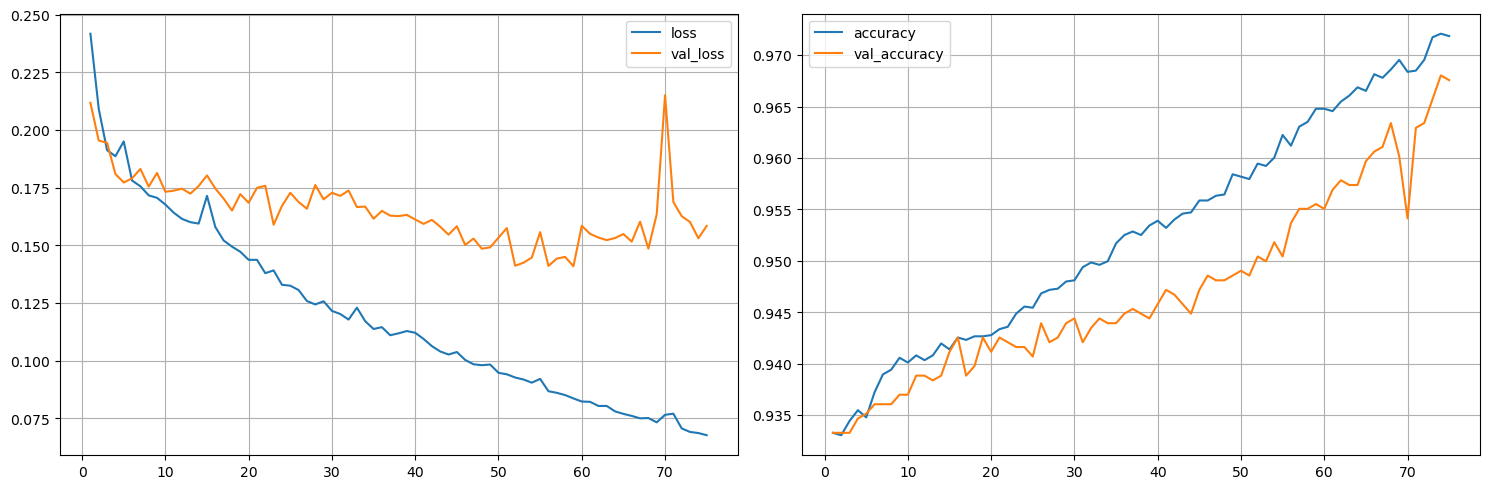

270/270 [==============================] - 3s 11ms/step - loss: 0.0677 - accuracy: 0.9718 - val_loss: 0.1584 - val_accuracy: 0.9676


In [13]:
# actual training..
callbacks_list = [PlotLearning()]
history = mdl.fit(X[train, ], y[train], epochs=75, validation_data=(X[test,], y[test]),callbacks=callbacks_list)

In [14]:
augmented_df.istSturz.sum()

720

In [17]:
# here we evaluate our trained model on all of the data, by adjusting the threshold  value we can manually test how clear the separation between positive and negative events really is
# in the current state the model is heavily overfitted
ypred = mdl.predict(X).ravel()
threshold = 0.10
pd.crosstab(augmented_df['event'], ypred >= threshold)

338/338 [==============================] - 1s 3ms/step


col_0,False,True
event,,
1.5L Flasche,657,63
2 Bücher,706,14
Dummy,35,685
Getränkeflasche,717,3
Handy,719,1
Hantel,701,9
Koffer,693,27
Krücken,713,7
Möbel verrücken,598,122


#### Next Steps

- Increase the final df with augmented dummy data from combination of traditional DA techniques - Done
- Test the classificator on the combination as well as the augmented positive events - Done
- Test the trained classificator with the real data as the test data 
- Implementation of VAE 
- Developing modules  - Done
- Comparison based on metrics(CNN, VAE, Trad.)